### Pablo Veloz M
## Desafío - Mecanismos de Votación

In [83]:
import aux_funciones as auxiliares
import helpers as helper
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

__Ejercicio 1 - Preparación del Ambiente de Trabajo__
- A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. 
- Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función grid_plot_batch que se encuentra en el archivo helpers.py .

In [48]:
df= pd.read_csv('./Archivo para desafío/OnlineNewsPopularity/OnlineNewsPopularity.csv')

In [49]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [50]:
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"),axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

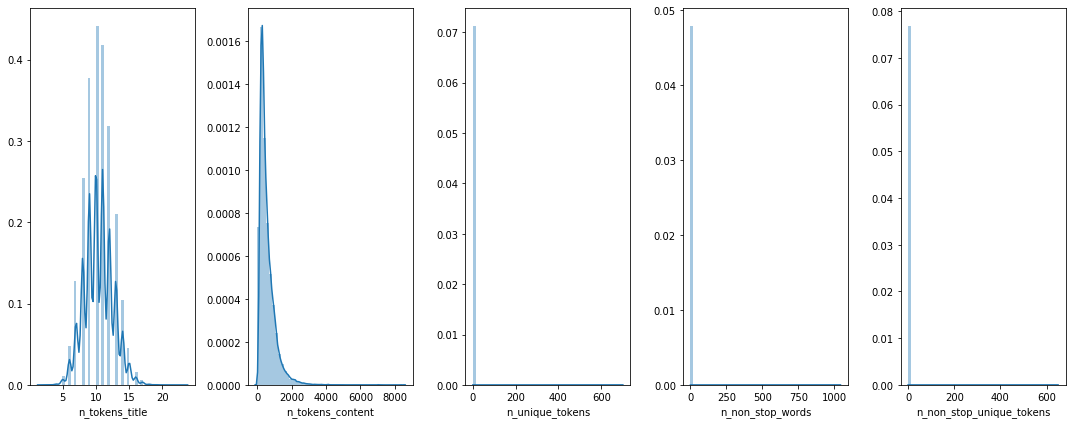

In [32]:
plt.figure(figsize=(15,6))
helper.grid_plot_batch(qnty,5,sns.distplot)

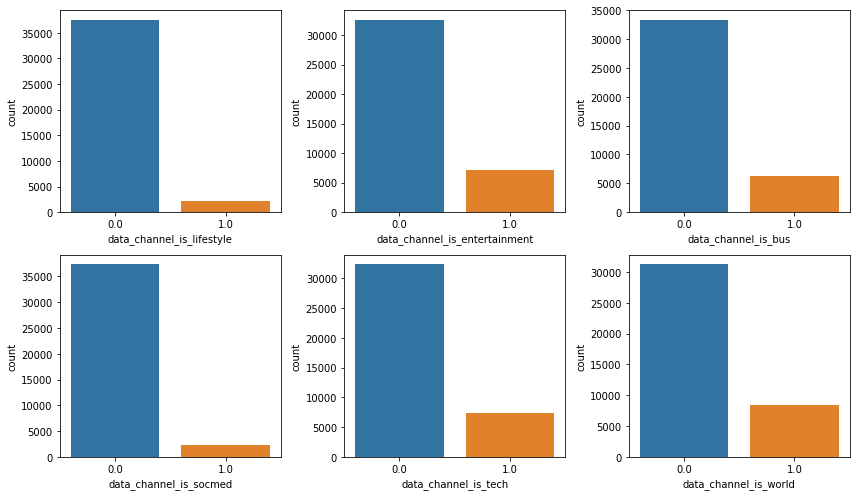

In [33]:
plt.figure(figsize=(12,7))
helper.grid_plot_batch(channel,3,sns.countplot)

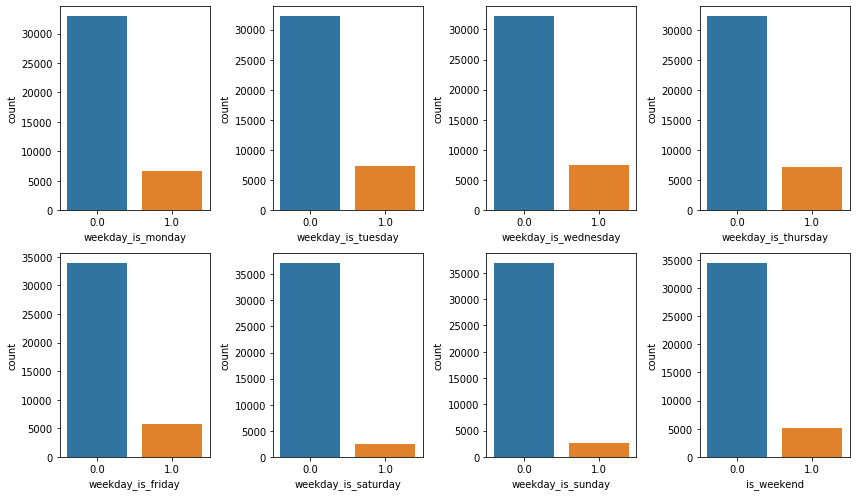

In [34]:
plt.figure(figsize=(12,7))
helper.grid_plot_batch(days,4,sns.countplot)

In [35]:
#df_numeric=df.select_dtypes(include=[np.float64,np.int64])
#df_numeric.columns
#auxiliares.distplot_num(df,df_numeric.columns,"url")

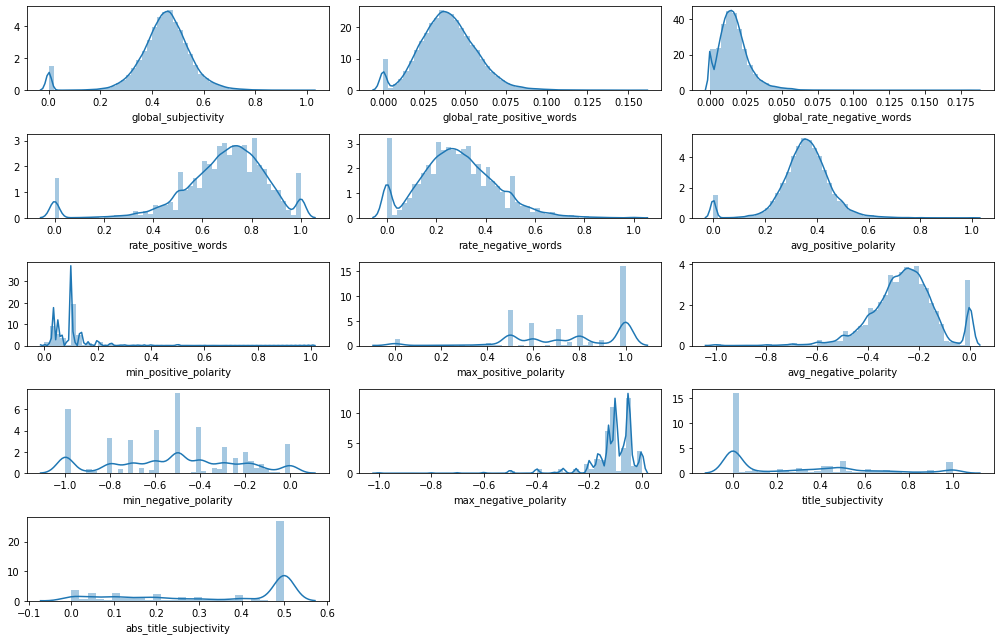

In [36]:
plt.figure(figsize=(14,9))
helper.grid_plot_batch(sentiments,3,sns.distplot)

In [37]:
#helper.grid_plot_batch(df.loc[:,['timedelta:shares'])

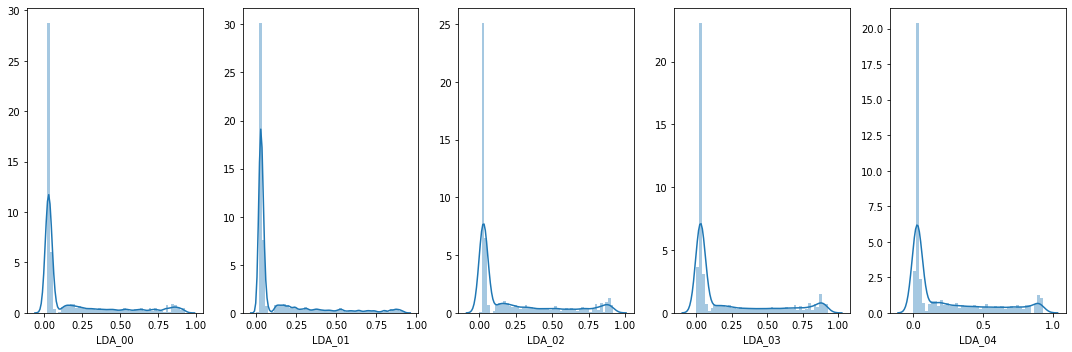

In [38]:
plt.figure(figsize=(15,5))
helper.grid_plot_batch(lda,5,sns.distplot)

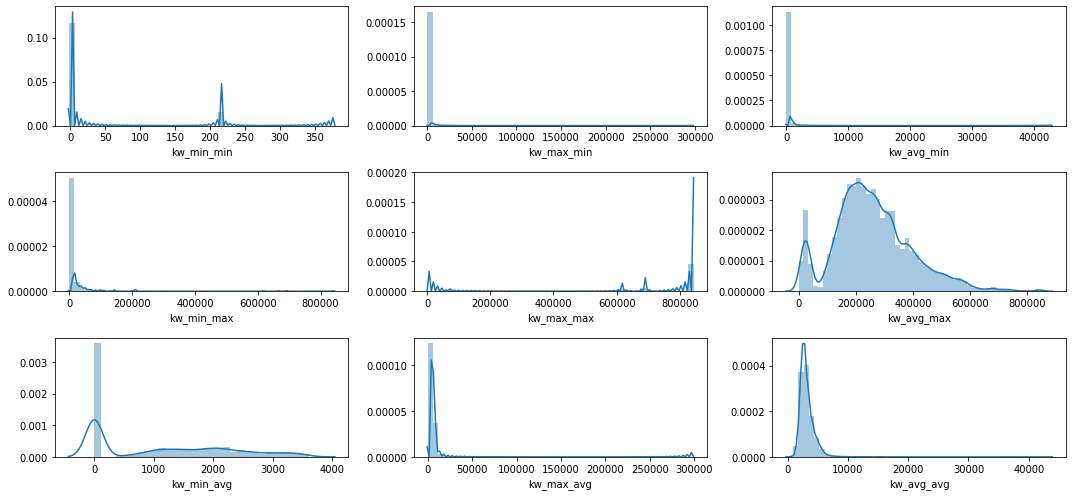

In [39]:
plt.figure(figsize=(15,7))
helper.grid_plot_batch(keywords,3,sns.distplot)

__Describa el comportamiento de las variables.__ 
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función `identify_high_correlations`que se encuentra en el archivo helpers.py . 
- Para todosaquellos atributos que tengan una correlación de .8, reporte sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, preprocese los datos con los siguientes pasos:
    - Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable shares posteriormente.
    - Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    - Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [51]:
df['shares_bin'] = np.where(df['shares'] > 1400, 1, 0)
df=df.drop('shares',axis=1)

In [52]:
listado_corr=helper.identify_high_correlations(df,threshold=0.8)

In [53]:
helper.identify_high_correlations(df,threshold=0.8)

,variable,var2,value
179,n_non_stop_words,n_unique_tokens,0.999572
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226
1499,kw_avg_avg,kw_max_avg,0.811864
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
1679,self_reference_avg_sharess,self_reference_max_shares,0.853480
2317,LDA_02,data_channel_is_world,0.836618


In [54]:
df=df.drop(listado_corr.variable,axis=1)

In [55]:
df.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity

In [58]:
x_mat=df.drop(columns='shares_bin',axis=1)
y_vec=df["shares_bin"]

In [59]:
X_train,X_test,y_train,y_test=train_test_split(x_mat,y_vec,test_size=.33,random_state=1)

In [61]:
categorical_train=X_train.filter(regex="__is__",axis=1)
numeric_train=X_train.drop(categorical_train.columns,axis=1)

In [62]:
categorical_test=X_test.filter(regex="__is__",axis=1)
numeric_test=X_test.drop(categorical_test.columns,axis=1)

In [64]:
from sklearn.decomposition import PCA
pca=PCA(n_components=30).fit(numeric_train)

In [65]:
numerical_pca_train=pca.transform(numeric_train)
numerical_pca_test=pca.transform(numeric_test)

In [71]:
f_train=pd.concat([pd.DataFrame(numerical_pca_train,categorical_train.reset_index(drop=True))],axis=1)

In [72]:
f_test=pd.concat([pd.DataFrame(numerical_pca_test,categorical_test.reset_index(drop=True))],axis=1)

__Ejercicio 2 - Evaluación de modelos individuales__

In [76]:
lr= LogisticRegression().fit(f_train,y_train)
lr_yhat=lr.predict(f_test)
print(classification_report(y_test,lr_yhat))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64      6598
           1       0.63      0.62      0.63      6485

    accuracy                           0.64     13083
   macro avg       0.64      0.64      0.63     13083
weighted avg       0.64      0.64      0.64     13083



In [77]:
svm=SVC().fit(f_train,y_train)
svm_yhat=svm.predict(f_test)
print(classification_report(y_test,svm_yhat))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      6598
           1       0.00      0.00      0.00      6485

    accuracy                           0.50     13083
   macro avg       0.25      0.50      0.34     13083
weighted avg       0.25      0.50      0.34     13083



In [82]:
gb=GradientBoostingClassifier().fit(f_train,y_train)
gb_yhat=gb.predict(f_test)
print(classification_report(y_test,gb_yhat))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66      6598
           1       0.66      0.64      0.65      6485

    accuracy                           0.66     13083
   macro avg       0.66      0.66      0.66     13083
weighted avg       0.66      0.66      0.66     13083



In [84]:
rf=RandomForestClassifier().fit(f_train,y_train)
rf_yhat=rf.predict(f_test)
print(classification_report(y_test,rf_yhat))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65      6598
           1       0.64      0.53      0.58      6485

    accuracy                           0.62     13083
   macro avg       0.62      0.62      0.62     13083
weighted avg       0.62      0.62      0.62     13083



In [87]:
dt1=DecisionTreeClassifier(max_depth=1,random_state=1).fit(f_train,y_train)
dt1_yhat=dt1.predict(f_test)
print(classification_report(y_test,dt1_yhat))

              precision    recall  f1-score   support

           0       0.65      0.27      0.38      6598
           1       0.53      0.86      0.66      6485

    accuracy                           0.56     13083
   macro avg       0.59      0.56      0.52     13083
weighted avg       0.60      0.56      0.52     13083



In [86]:
dt2=DecisionTreeClassifier(max_depth=4,random_state=1).fit(f_train,y_train)
dt2_yhat=dt2.predict(f_test)
print(classification_report(y_test,dt2_yhat))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58      6598
           1       0.58      0.65      0.61      6485

    accuracy                           0.60     13083
   macro avg       0.60      0.60      0.59     13083
weighted avg       0.60      0.60      0.59     13083



__Ejercicio 3 - Entrenamiento de Comité__

In [89]:
from sklearn.ensemble import VotingClassifier